<img src="http://image.noelshack.com/fichiers/2022/42/3/1666174797-npix.png" style="width:7px"/> <img src="http://image.noelshack.com/fichiers/2022/42/3/1666174264-python.png" style="width:50px"/>   <font size="+3"> <b> NeuroPyxels quickstart </b> </font> <img src="http://image.noelshack.com/fichiers/2022/42/3/1666174264-python.png" style="width:50px"/> <img src="http://image.noelshack.com/fichiers/2022/42/3/1666174797-npix.png" style="width:7px"/>

Put together for UCL Neuropixels course, October 2022

Github repo: https://github.com/m-beau/NeuroPyxels

Install with `pip install npyx` in your favorite environment!

#### Imports

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [25]:
# Ensures that npyx will ACTUALLY be reimported in a running session
%reload_ext autoreload
%autoreload 2
from npyx import *

## 1 - Loading Neuropixels data

First, fill in the path to your spike-sorted Neuropixels dataset (e.g. sorted with kilosort and curated with phy)

In [26]:
dp = "/media/maxime/AnalysisSSD/test_dataset" # dp stands for datapath

### 1.1 - Load Neuropixels sync channel, metadata

In [28]:
# Threshold crosses of the sync channel acquired with the SMA port on the acquisition board
onsets, offsets = get_npix_sync(dp)
onsets

{6: array([   6.26276667,  385.3498    ,  385.37483333, ..., 1265.5021    ,
        1280.86823333, 1296.20936667])}

In [29]:
# blah.ap.meta file contents and more
meta = read_metadata(dp)
print(f"Neuropixels probe {meta['probe_version']} acquired with {meta['acquisition_software']}.")
fs = meta['highpass']['sampling_rate']
print(f"Highpass filtered data at {meta['highpass']['binary_relative_path']} was acquired at {fs} Hz.")

Neuropixels probe 1.0 acquired with SpikeGLX.
Highpass filtered data at ./test_dataset.ap.bin was acquired at 30000 Hz.


### 1.2 Load units and unit qualities (good, mua, noise...)

In [30]:
all_units = get_units(dp)
good_units = get_units(dp, "good")
good_units

array([  2,   3,   5,   7,  12,  14,  19,  20,  21,  22,  24,  25,  26,
        27,  35,  40,  69,  72,  76,  85, 103, 110, 117, 119, 150, 174,
       175, 178, 215, 277, 279, 280, 282, 297, 300, 303, 304, 306, 308,
       386])

### 1.3 - Load spike trains

Neuron 3 has 150306 spikes.


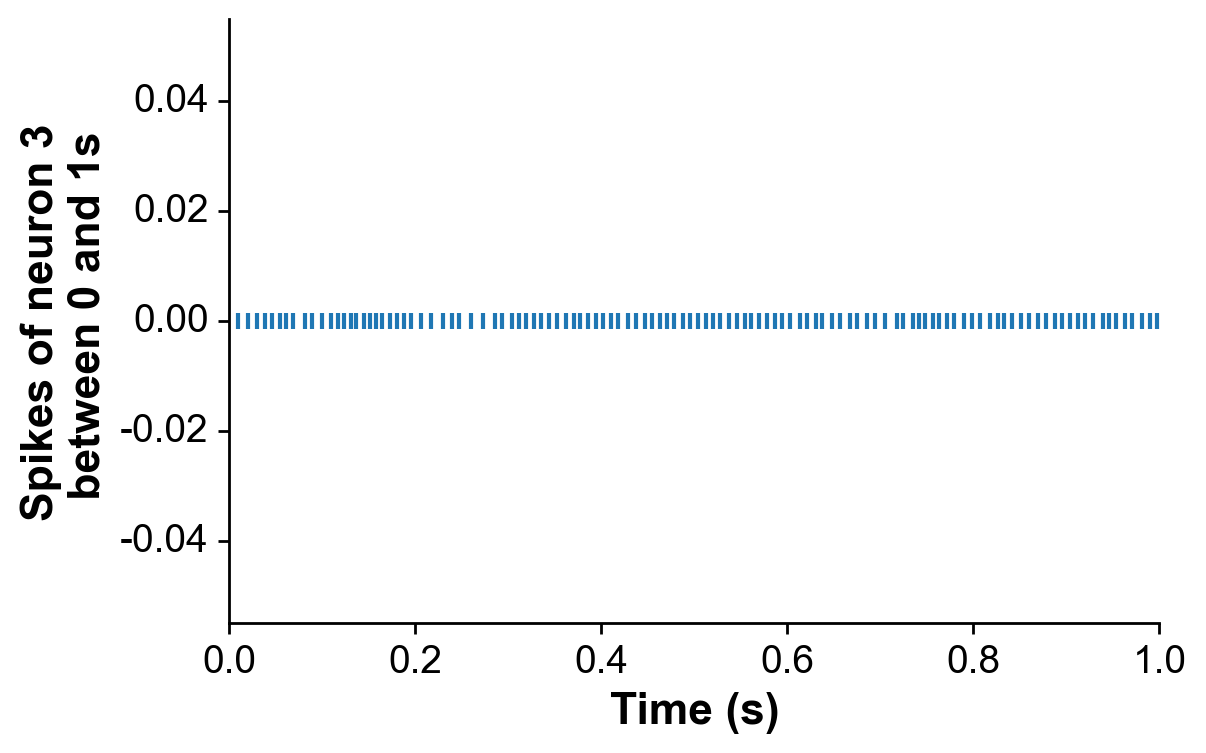

In [31]:
# pick unit
u = good_units[1]

# Load spikes 
t = trn(dp, u)
print(f"Neuron {u} has {t.shape[0]} spikes.")
t = t / fs # convert from samples to seconds

# Plot
plt.scatter(t, t*0, marker="|")
fig = mplp(xlim = [0,1], ylabel = f"Spikes of neuron {u}\n between 0 and 1s", xlabel = "Time (s)")

### 1.4 - Load spike waveforms

wvf() returns an array of shape 100 spikes by 82 samples (time) by 384 channels.
We define the peak channel as the channel with maximum amplitude: here 2


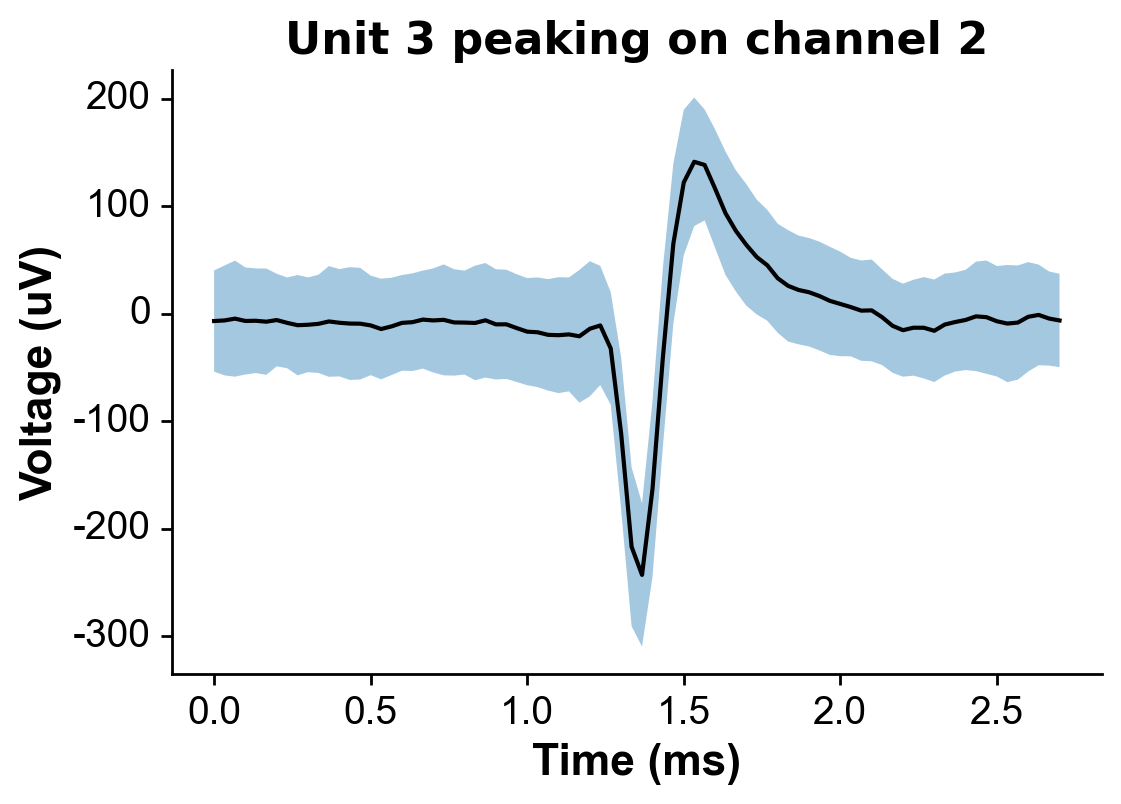

In [32]:
# load waveform
waveforms = wvf(dp, u)
spikes, samples, channels = waveforms.shape
print(f"wvf() returns an array of shape {spikes} spikes by {samples} samples (time) by {channels} channels.")

# Find peak channel
peak_channel = waveforms.mean(0).max(0).argmax()
print(f"We define the peak channel as the channel with maximum amplitude: here {peak_channel}")

# Plot
w_time = np.arange(samples) * 1000 / fs
w = waveforms.mean(0)[:,peak_channel]
w_s = waveforms.std(0)[:,peak_channel]
plt.fill_between(w_time, w+w_s, w-w_s, alpha=0.4)
plt.plot(w_time, w, color="k")
fig = mplp(title = f"Unit {u} peaking on channel {peak_channel}", xlabel = "Time (ms)", ylabel = "Voltage (uV)")

### Or you can directly plot them, according to your probe's channel map:

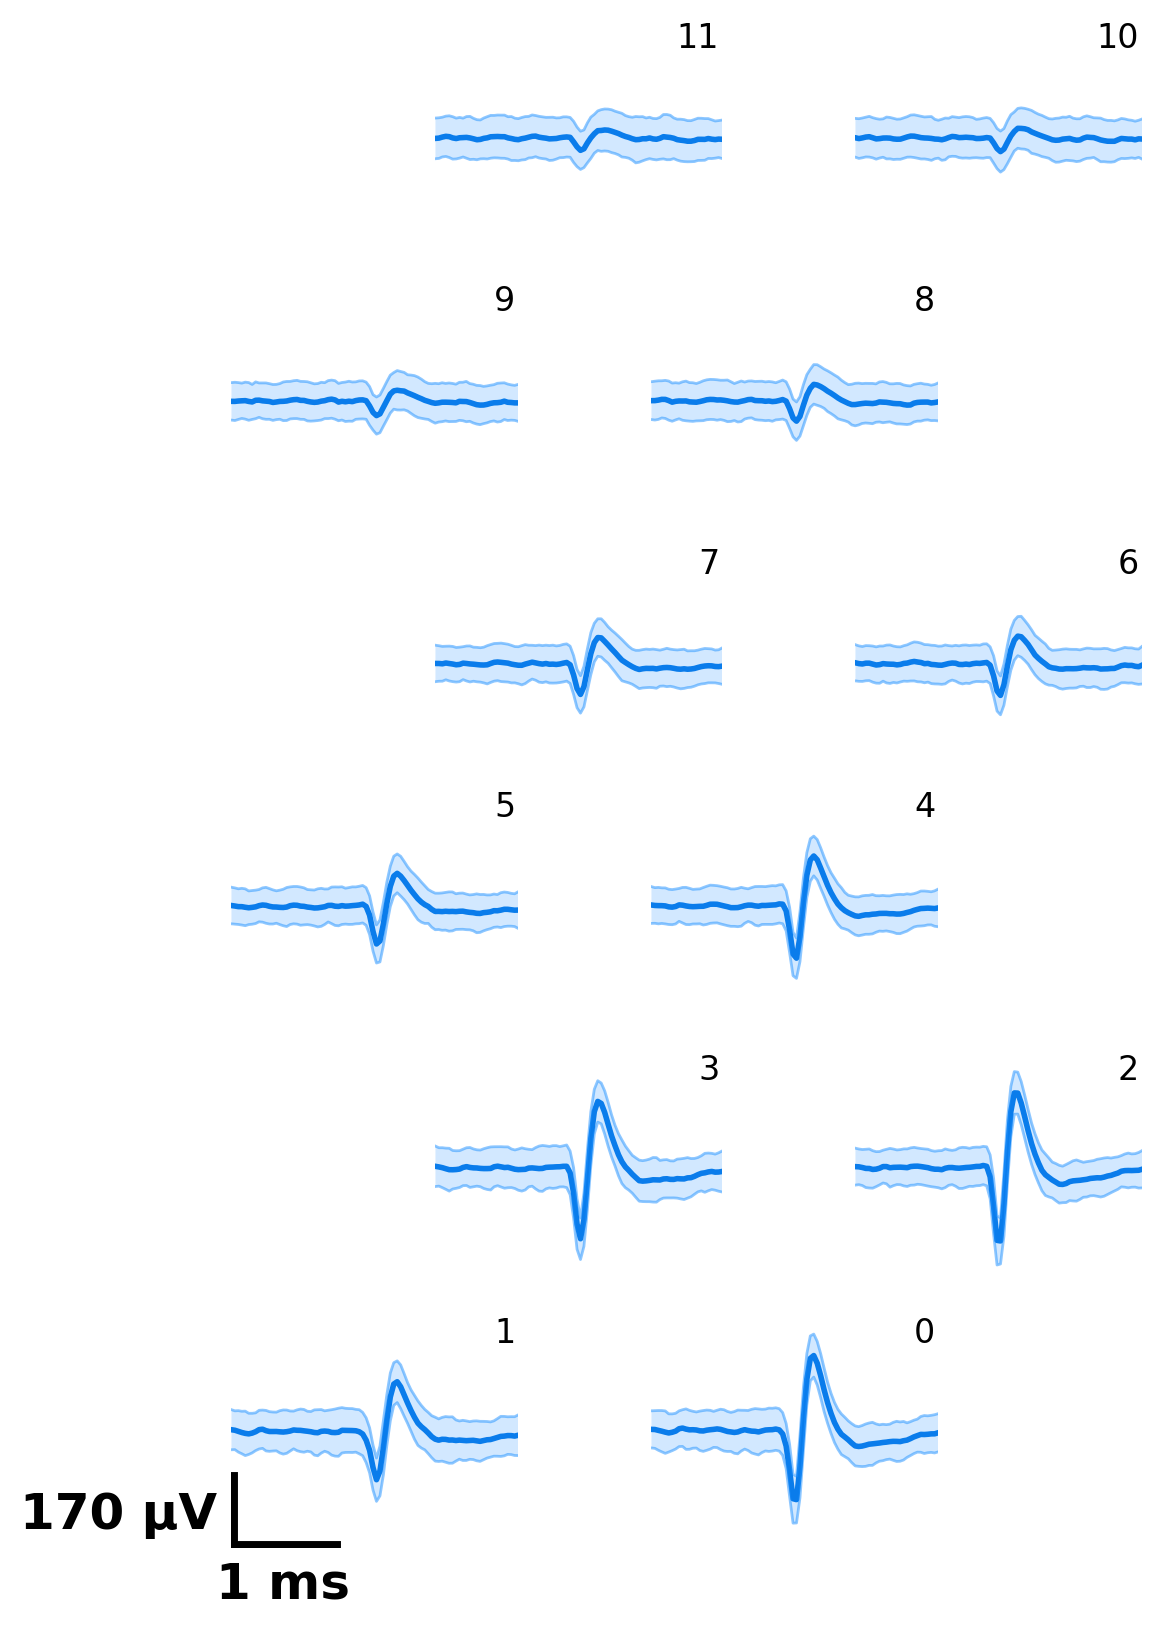

In [33]:
# it will find the peak channel by itself
fig = plot_wvf(dp, u, Nchannels=12, t_waveforms=2.8)

### 1.5 Load raw data

extract_rawChunk() returns an array of shape 384 channels x 2100 samples (70ms)


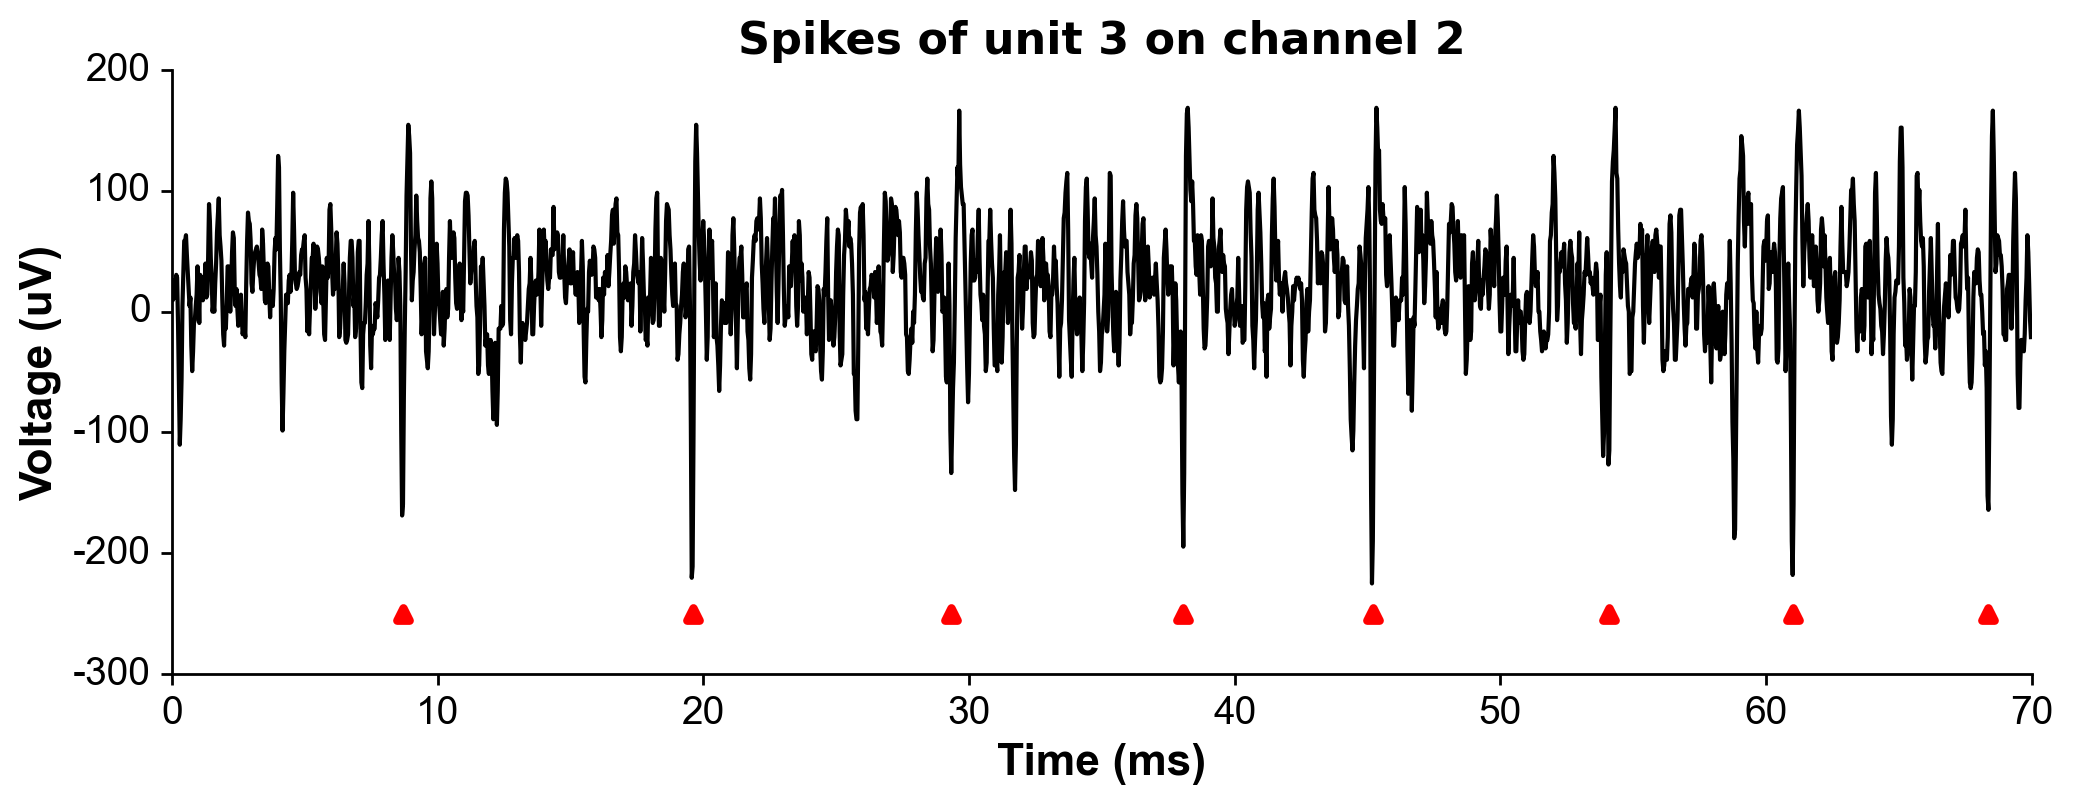

In [34]:
# Load raw data
raw_data_chunk = extract_rawChunk(dp, [0, 0.07])
channels, samples = raw_data_chunk.shape
print(f"extract_rawChunk() returns an array of shape {channels} channels x {samples} samples ({round(samples/30)}ms)")
plt.plot(np.arange(samples)/30, raw_data_chunk[peak_channel], color='k')
plt.scatter(t* 1000, t * 0 - 250, color="red", marker="^", lw=3, s=20)
fig = mplp(figsize = (12,4), title = f"Spikes of unit {u} on channel {peak_channel}", xlim = [0, samples * 1000 / fs], ylim = [-300, 200],
           xlabel = "Time (ms)", ylabel = "Voltage (uV)")

### or you can directly overlay the spikes of one or several unit on the raw data!

plotting unit 14...
plotting spike 0/4...
plotting spike 1/4...
plotting spike 2/4...
plotting spike 3/4...
plotting unit 3...
plotting spike 0/8...
plotting spike 1/8...
plotting spike 2/8...
plotting spike 3/8...
plotting spike 4/8...
plotting spike 5/8...
plotting spike 6/8...
plotting spike 7/8...


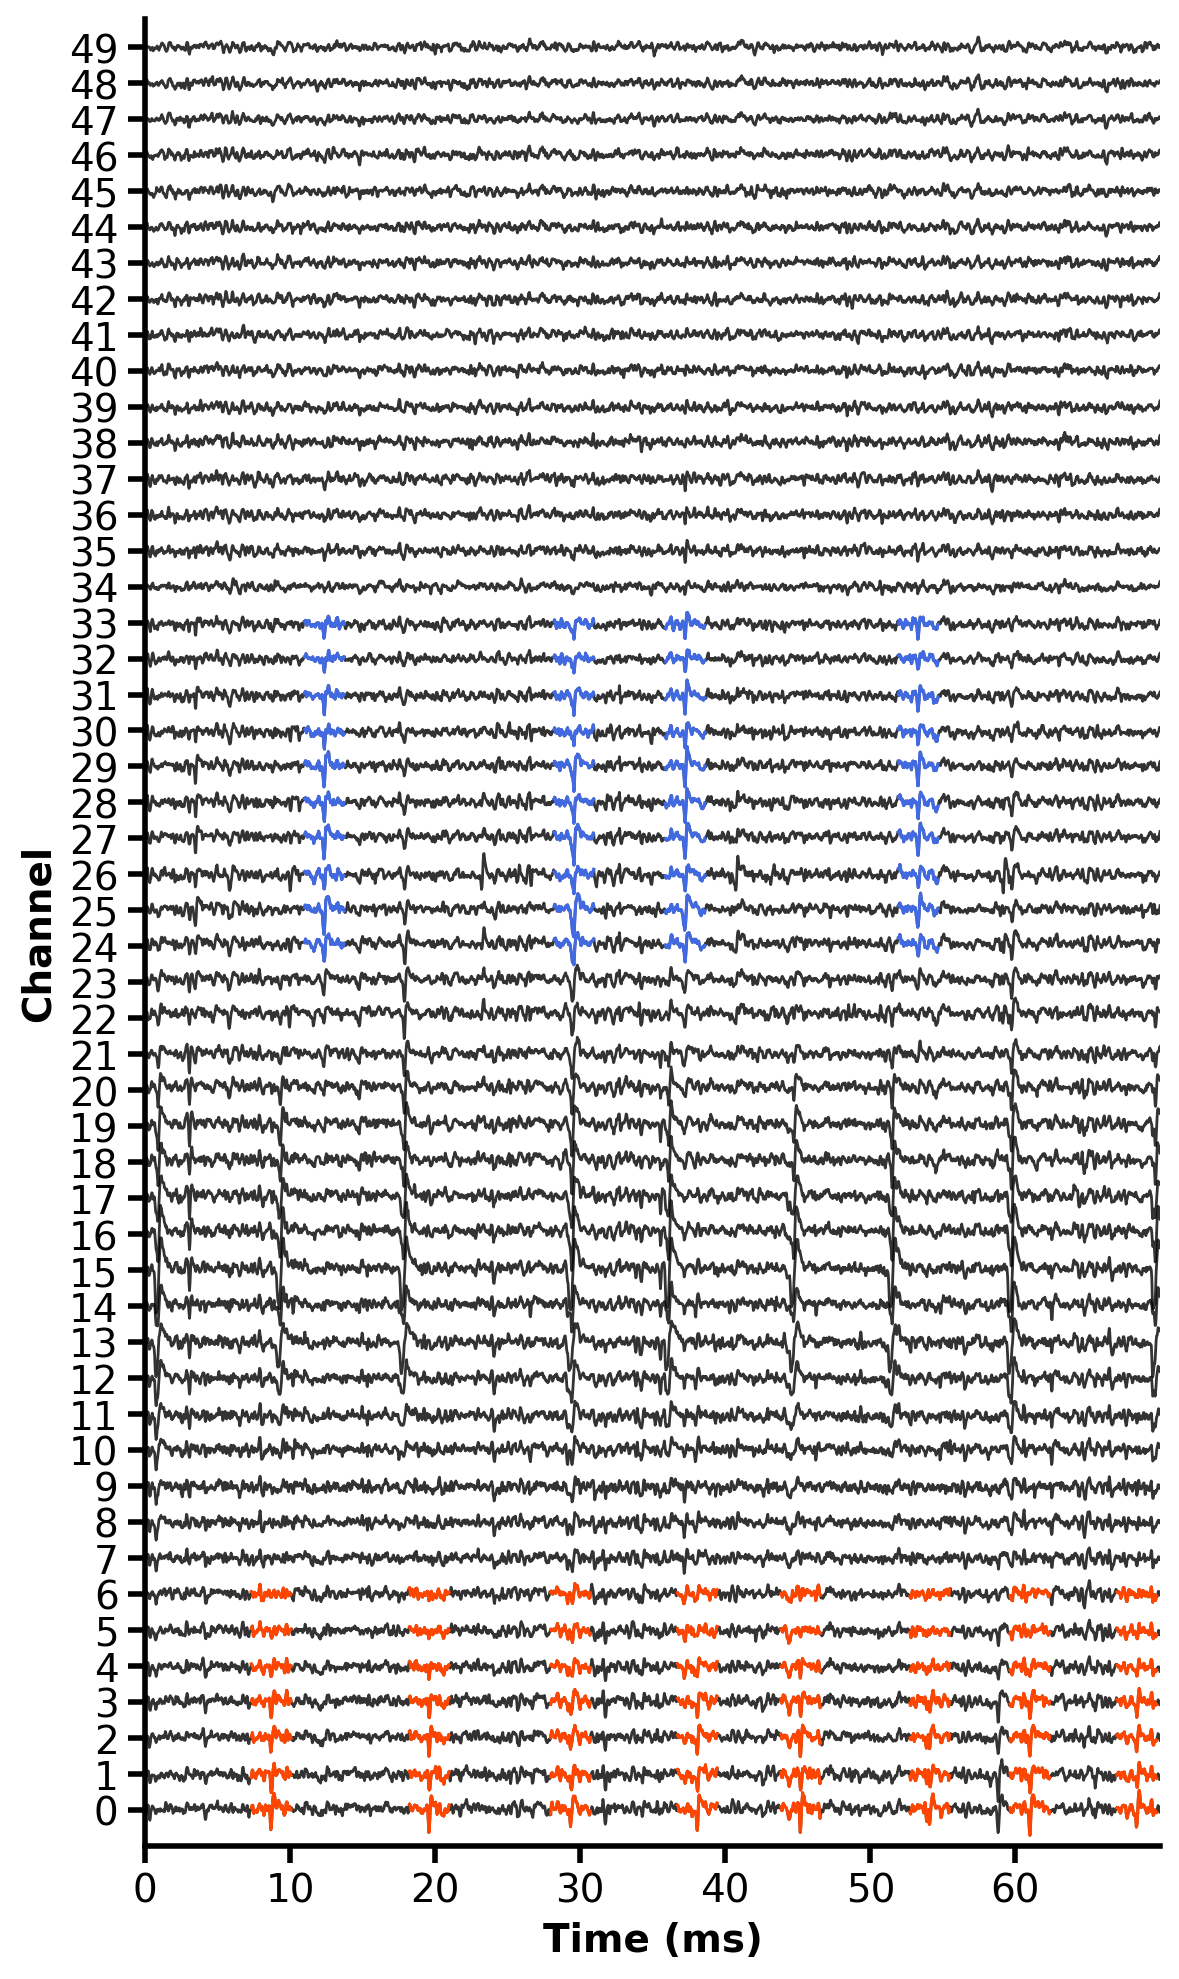

In [35]:
fig = plot_raw_units(dp, times=[0,0.07], units = [14, u], channels = np.arange(50),
               colors=['royalblue', 'orangered'], yticks_jump = 1, figsize=(6,10),
               offset=450,  Nchan_plot=10)

## 2 - Processing Neuropixels data

### 2.1 - Raw data preprocessing

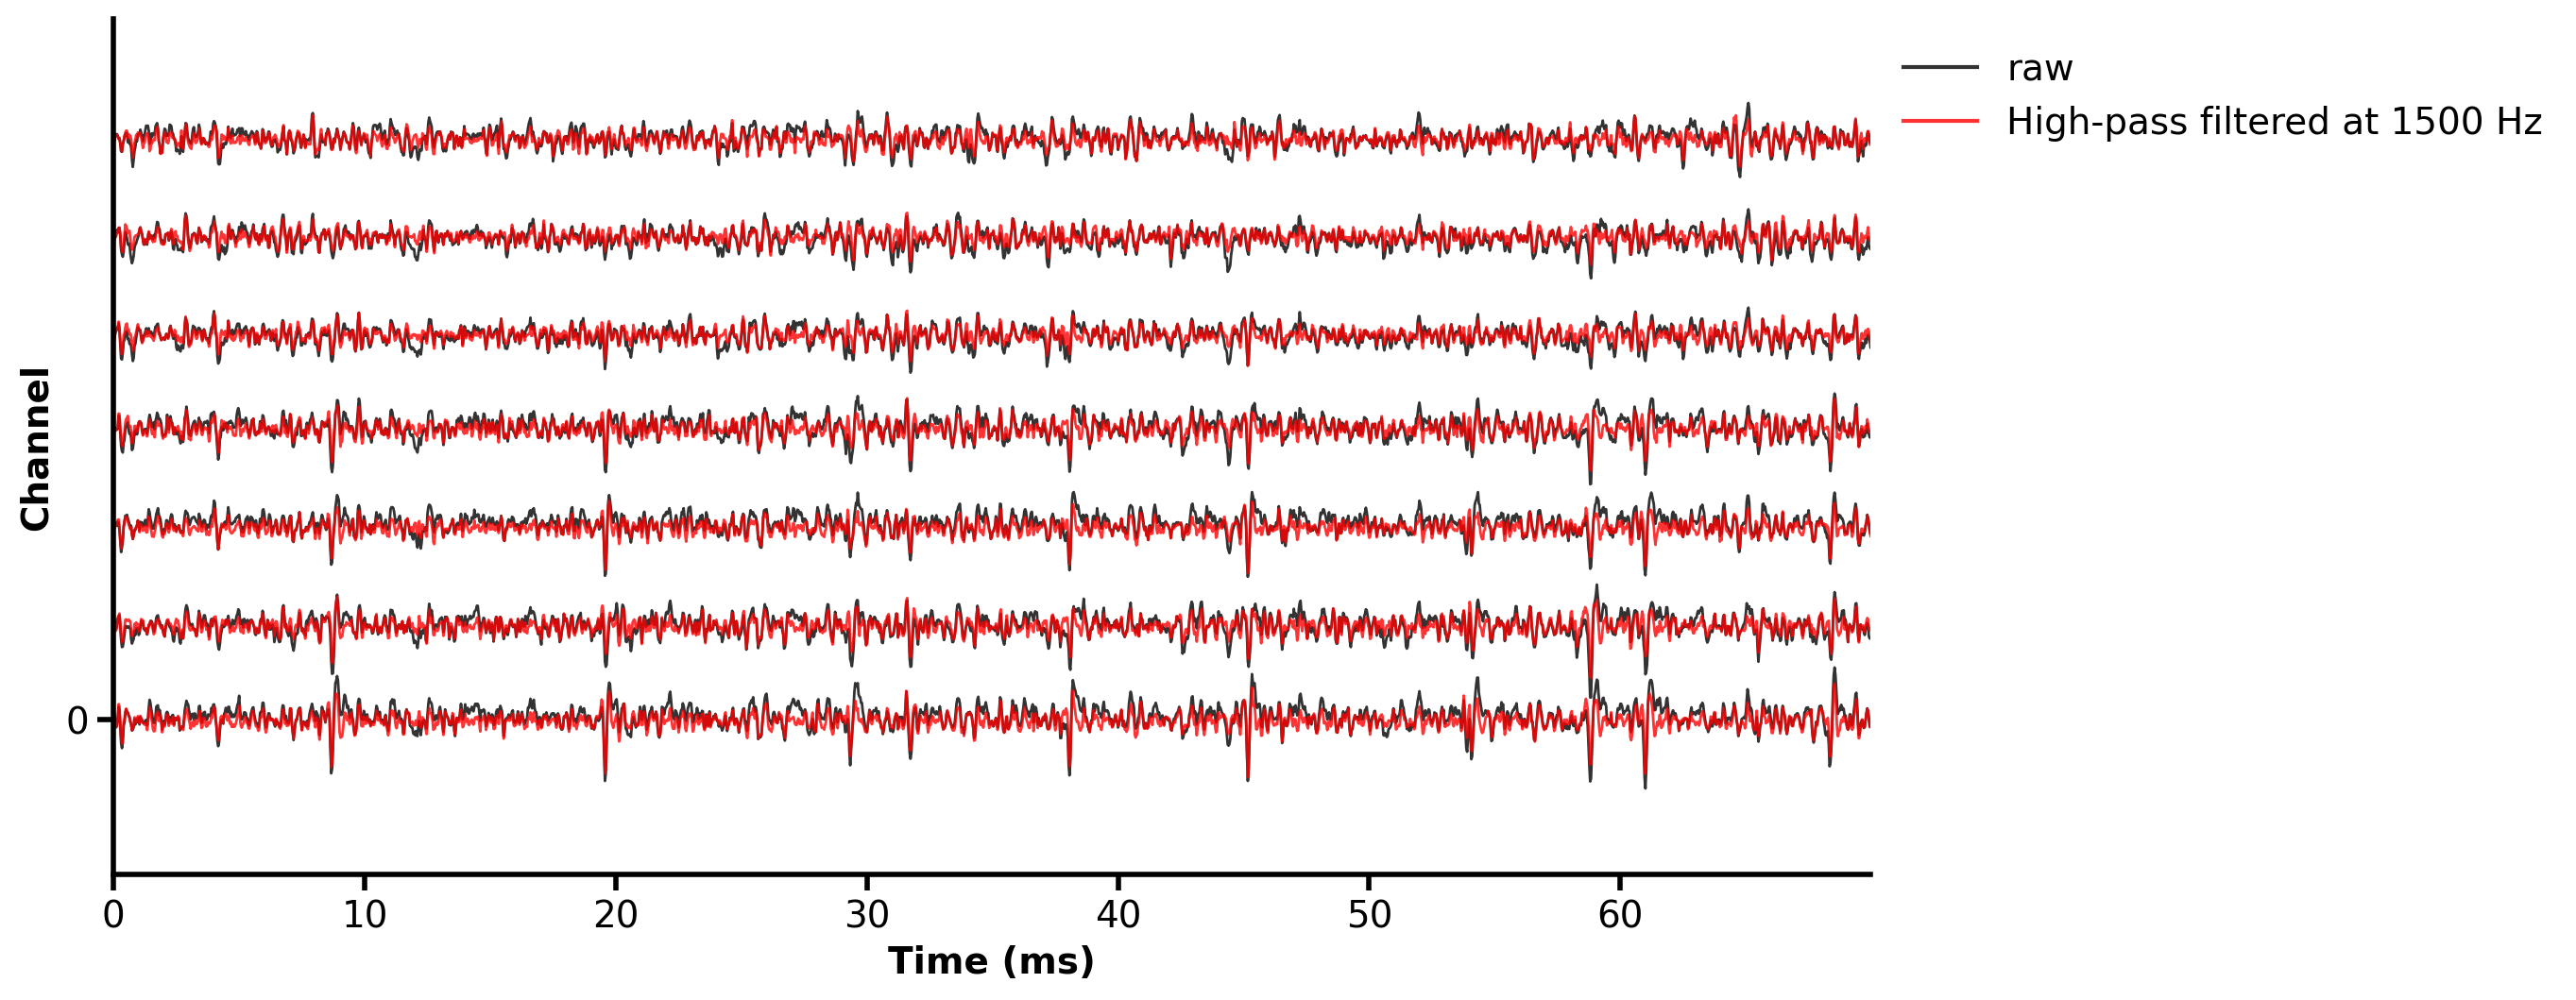

In [36]:
fig = plot_raw(dp, times=[0,0.07], channels = np.arange(7),
               yticks_jump = 1, figsize=(12,6), legend="raw")
fig = plot_raw(dp, times=[0,0.07], channels = np.arange(7),
               
               whiten=False, med_sub=False, hpfilt=True, hpfiltf=1500, nRangeWhiten=None, nRangeMedSub=None, use_ks_w_matrix=False, # <<<<<
               
               color = 'red', ax = fig.get_axes()[0], legend="High-pass filtered at 1500 Hz")

### 2.2 - Compute crosscorrelograms FAST

In [37]:
c = ccg(dp, good_units[:20], bin_size=0.2, win_size=80) # computes 400 crosscorrelograms - takes 3s
print(f"{20*20/2-20} crossocrrelograms computed. Array shape: {c.shape}.")

180.0 crossocrrelograms computed. Array shape: (20, 20, 401).


### or plot them directly

Plotting CCGs:   0%|          | 0/3 [00:00<?, ?it/s]

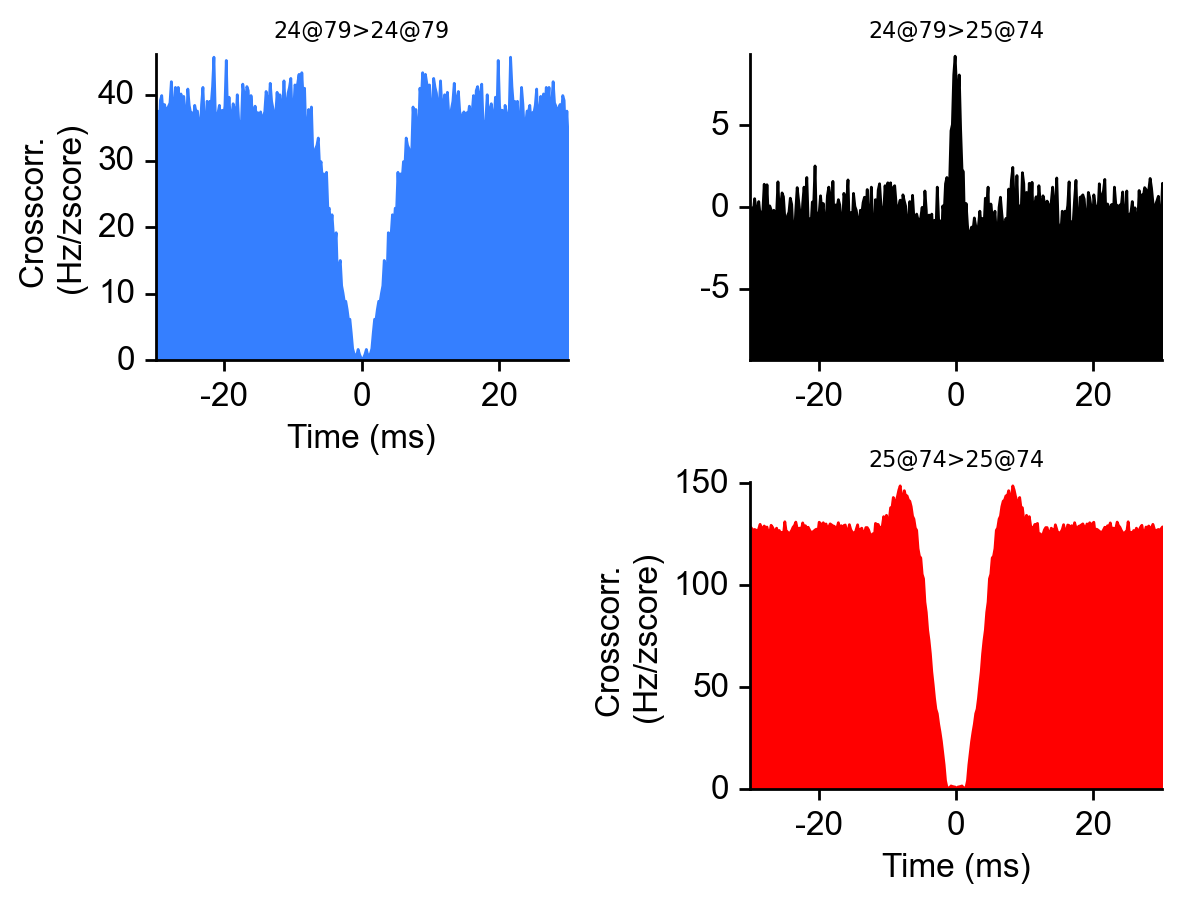

In [38]:
fig = plot_ccg(dp, [24,25], 0.2, 60, as_grid=True, figsize = (6,5))

### 2.3 - Drift-correcting and realigning waveforms

In [39]:
w_preprocessed = wvf_dsmatch(dp, u, plot_debug=True)

### 2.3 - Dynamic estimate of false positive and false negative rates

In [40]:
u_fpfn = good_units[-9]
t_preprocessed, t_preprocessed_mask = trn_filtered(dp, u_fpfn, plot_debug=True, again=True)
print(f"Out of the {trn(dp,u_fpfn).shape[0]} spikes of unit {u_fpfn}, {t_preprocessed.shape[0]} belong to a section with less than 5% of false positive and false negative rates.")

Out of the 73284 spikes of unit 280, 55892 belong to a section with less than 5% of false positive and false negative rates.


### 2.4 - Easily explore functional connectivity between neurons

Found 29 units above 40Hz.


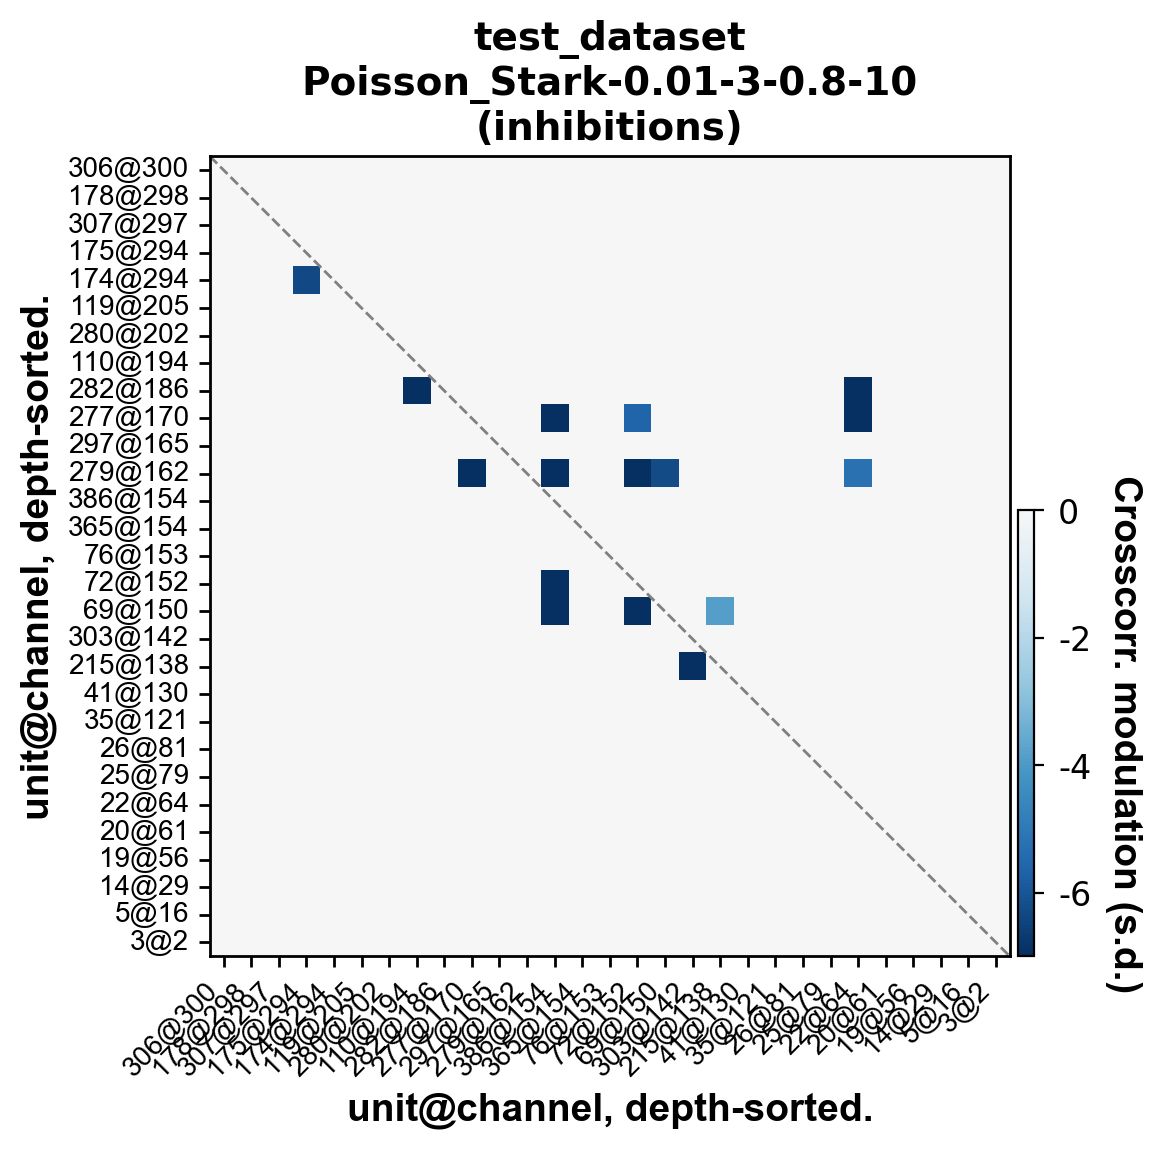

In [41]:
# CCGs parameters
cbin=0.5
cwin=100
n_consec_bins=3
corr_type='inhibitions' #'synchrony'

# significance test parameters
p_th=0.01
fract_baseline=4./5
W_sd=10
test='Poisson_Stark'

mfr_th = 40
units=[u for u in get_units(dp) if mfr(dp,u)>mfr_th]
print(f'Found {len(units)} units above {mfr_th}Hz.')

fig=plot_sfcm(dp, corr_type=corr_type, metric='amp_z', cbin=cbin, cwin=cwin,
              p_th=p_th, n_consec_bins=n_consec_bins, fract_baseline=fract_baseline, W_sd=W_sd, test=test,
              drop_seq=['sign', 'time', 'max_amplitude'],
              units=units, name=f'all_units_move_{mfr_th}Hz',
              text=False, markers=False, ticks=True, depth_ticks=False,
              regions={},reg_colors={},
              vminmax=[-7,7], figsize=(4,4),
              saveFig=False, saveDir=dp, again=False, againCCG=0, use_template_for_peakchan=True,
              periods='all')

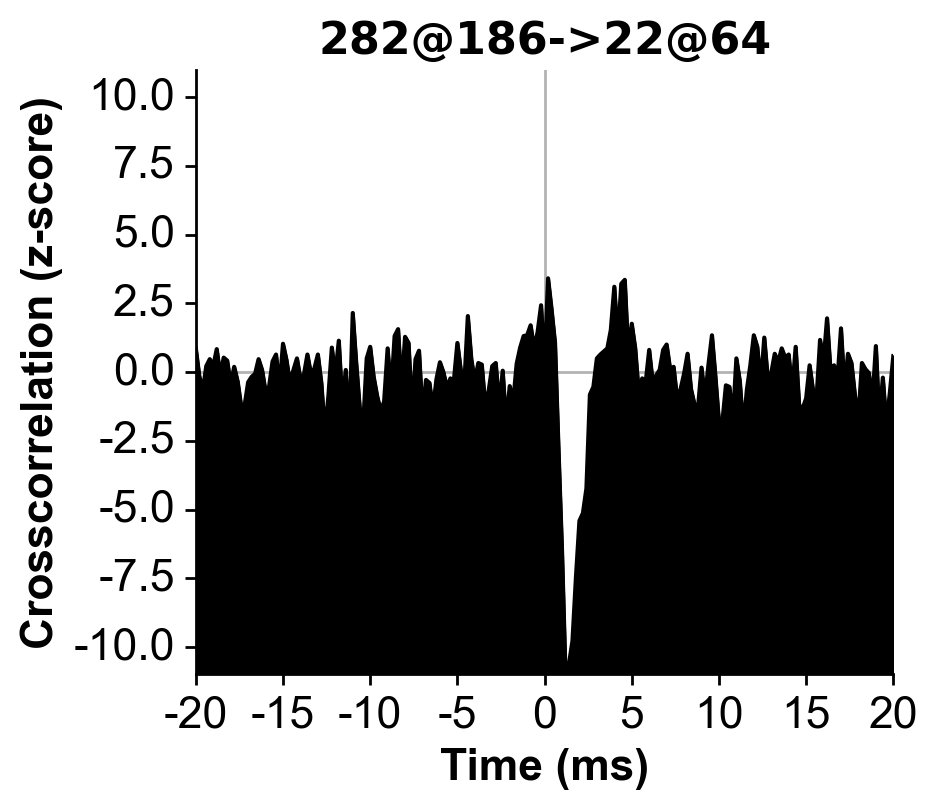

In [42]:
fig = plot_ccg(dp, [282,22], 0.2, 40)

### 2.5 - Merge datasets acquired on 2 Neuropixels probes simultaneously

In [ ]:
from npyx.merger import merge_datasets 
dps = ['same_folder/lateralprobe_dataset',
       'same_folder/medialprobe_dataset',
       'same_folder/anteriorprobe_dataset']
probenames = ['lateral','medial','anterior']
dp_dict = {p:dp for p, dp in zip(probenames, dps)}

dp_merged, datasets_table = merge_datasets(dp_dict)

### Bonus: Make Pretty MatPlotLib = Make PLot Pretty = mplp()

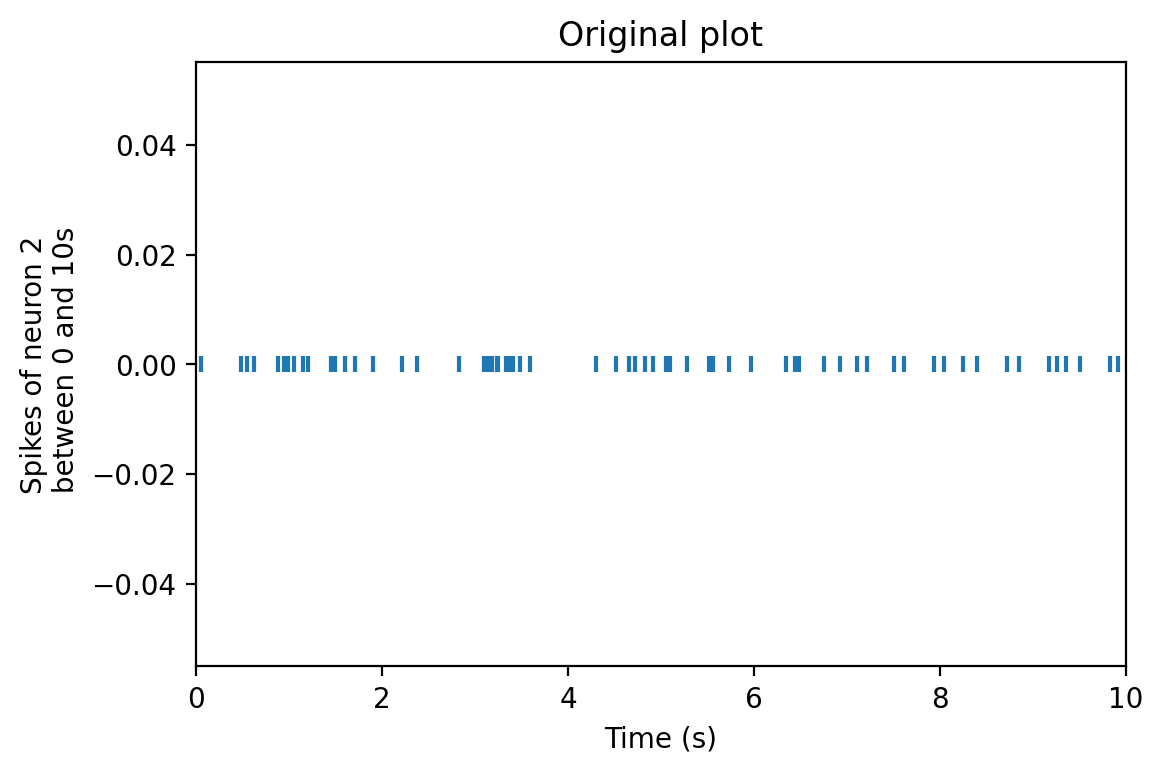

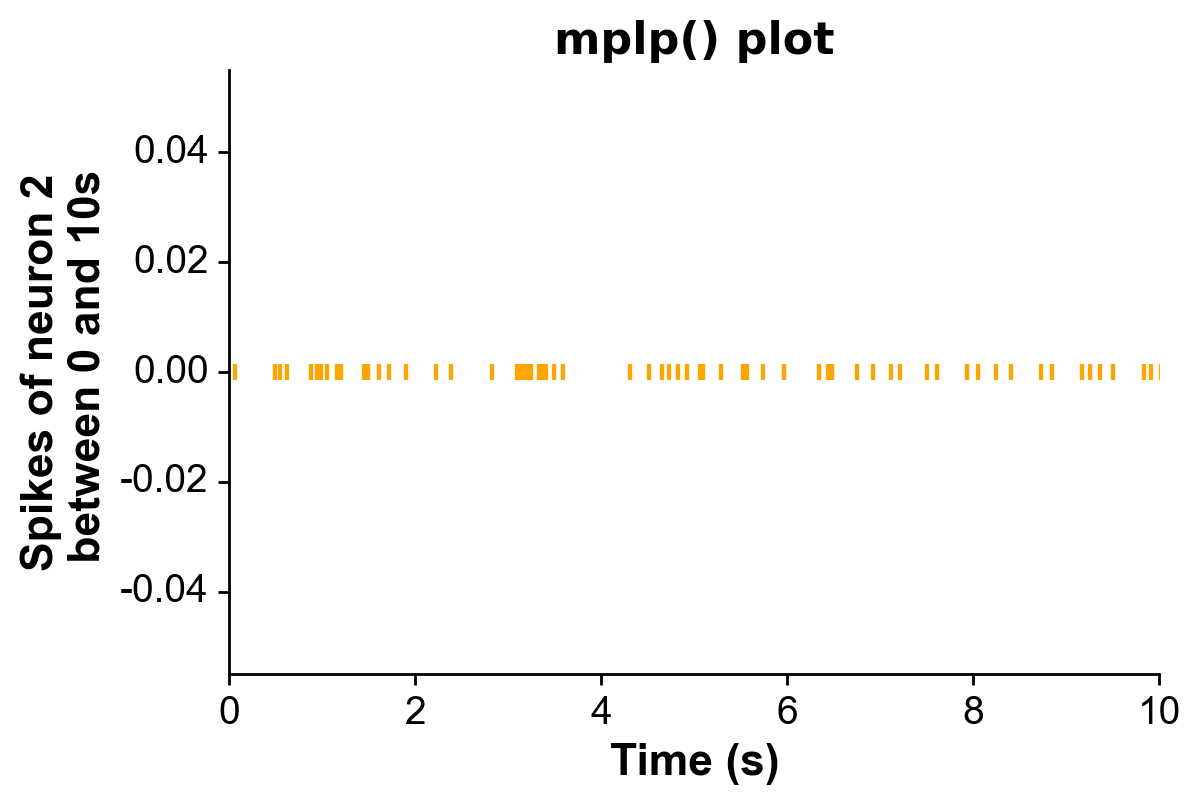

In [21]:
t = trn(dp, 2) / meta['highpass']['sampling_rate']

# default matplotlib style
plt.figure()
plt.scatter(t, t*0, marker="|")
plt.title("Original plot")
plt.xlim([0,10])
plt.ylabel("Spikes of neuron 2\n between 0 and 10s")
plt.xlabel("Time (s)")

# using mplp()
# makes most common matplotlib options easily accessible as function parameters
plt.figure()
plt.scatter(t, t*0, marker="|", color="orange")
t = trn(dp, 2) / meta['highpass']['sampling_rate']
plt.scatter(t, t*0, marker="|", color="orange")
#############
fig = mplp(xlim = [0,10], title = "mplp() plot",
     ylabel = "Spikes of neuron 2\n between 0 and 10s",
     xlabel = "Time (s)")
#############

### Bonus: display matplotlib colormaps

In [22]:
colors = get_ncolors_cmap('coolwarm', 10, plot=1)
colors = get_ncolors_cmap('viridis', 10, plot=1)